In [2]:
import numpy as np 
from darkspirals.disc import Disc
import numpy as np
import matplotlib.pyplot as plt
from darkspirals.distribution_function.compute_df import compute_df_from_orbits, compute_df_from_actions
from darkspirals.orbit_util import integrate_single_orbit, sample_sag_orbit, satellite_vertical_force
from darkspirals.substructure.halo_util import sample_dwarf_galaxy_potential_nfw
from galpy.potential import MovingObjectPotential
from galpy.potential import toVerticalPotential
from galpy.potential import MWPotential2014
from darkspirals.substructure.realization import SubstructureRealization
import astropy.units as apu 
from galpy.orbit import Orbit

z_min_max = 1.0 * 0.75
vz_min_max = 60 * 0.75
phase_space_resolution = 100
z = np.linspace(-z_min_max,z_min_max,phase_space_resolution)
vz = np.linspace(-vz_min_max, vz_min_max, phase_space_resolution)
galactic_potential = MWPotential2014
time_Gyr = np.linspace(0.0, -1., 800) * apu.Gyr

disc = Disc(galactic_potential, galactic_potential, z_min_max, vz_min_max, phase_space_resolution, 
            time_Gyr, parallelize_action_angle_computation=True, compute_upfront=True)

A new version of galpy (1.10.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


### set up a perturber orbit

[[ 3.22074295 -0.23493786  0.31480644  3.46572     0.31053938  0.25848025]]


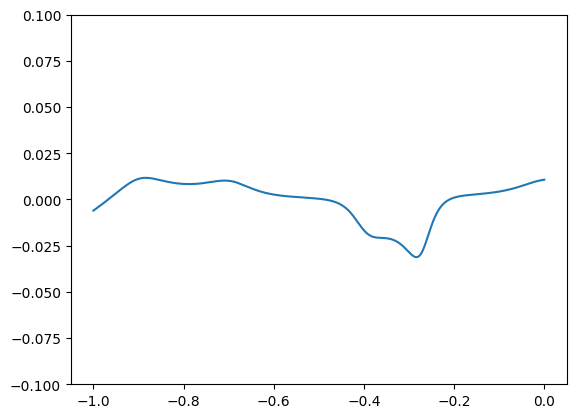

In [3]:
r_min = 2
np.random.seed(30 + 5)
realization = SubstructureRealization.withDistanceCut(disc, norm=0.0, r_min=r_min, 
                                                      num_halos_scale=1.0, 
                     
                                                      m_low=10**6.7, 
                                                      m_high=10**8.0, 
                                                      t_max=-1.2)
realization.add_dwarf_galaxies(add_orbit_uncertainties=True, 
                               tidal_stripping=False,
                                       include_dwarf_list=['Willman I'], 
                               log10_dsphr_masses={'Willman I': 10.6})
f = realization.orbits[0].force_exerted(disc)
plt.ylim(-0.1, 0.1)
print(realization.orbits[0].vxvv)
plt.plot(time_Gyr, f); plt.show()

### Do the calculation with the code

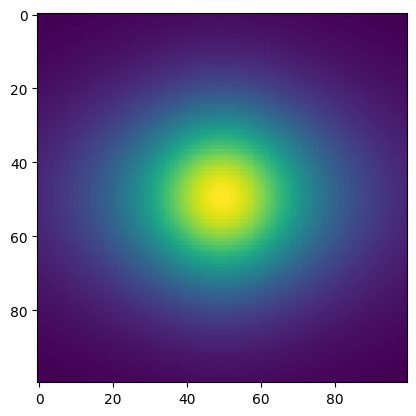

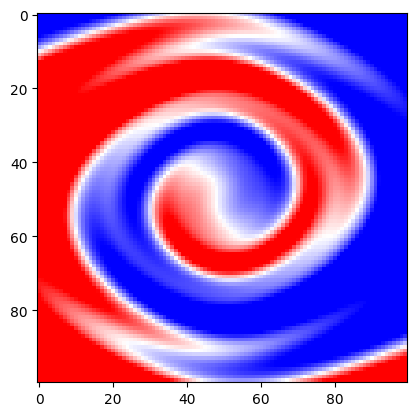

In [4]:
df_model='LI&WIDROW'
velocity_dispersion = 15.2
equilibrium_df = compute_df_from_actions(disc, 
                            velocity_dispersion, 
                            0.0,
                            df_model=df_model)
force = disc.compute_satellite_forces(realization.orbits, realization.potentials)[0]
deltaJ_approx = disc.compute_deltaJ_from_forces(force)
df_perturbed = compute_df_from_actions(disc, velocity_dispersion, deltaJ_net=deltaJ_approx,
                                      df_model='LI&WIDROW')

plt.imshow(np.rot90(equilibrium_df.function), origin='upper', cmap='viridis')
plt.show()

plt.imshow(np.rot90(df_perturbed.function / equilibrium_df.function), origin='upper', cmap='bwr', vmin=0.8, vmax=1.2)
plt.show()

In [ ]:
# Jz_initial_approx, angle_initial_approx, freq_initial_approx, weights_initial_approx = equilibrium_df.sample_action_angle_freq(disc, 
#                                                                                                                N_samples=10000)
# Jz_final_approx, angle_final_approx, freq_final_approx, weights_final_approx = df_perturbed.sample_action_angle_freq(disc, 
#                                                                                                                N_samples=10000)

In [ ]:
# plt.hist(angle_initial_approx, weights=weights_initial_approx, bins=15, color='k', alpha=0.5)
# plt.hist(angle_final_approx, weights=weights_final_approx, bins=15, color='r', alpha=0.5); plt.show()

# plt.hist(freq_initial_approx, weights=weights_initial_approx, bins=15, color='k', alpha=0.5)
# plt.hist(freq_final_approx, weights=weights_final_approx, bins=15, color='r', alpha=0.5); plt.show()

# plt.scatter(Jz_initial_approx, angle_initial_approx, color='k',s=0.1)
# plt.scatter(Jz_final_approx, angle_final_approx, color='r',s=0.1); plt.show()

# plt.scatter(Jz_initial_approx, freq_initial_approx, color='k',s=0.1)
# plt.scatter(Jz_final_approx, freq_final_approx, color='r',s=0.1); plt.show()

### Direct orbit integration of stars with perturber in MWPotential2014

In [5]:
perturbing_potential = MovingObjectPotential(realization.orbits[0], pot=realization.potentials[0])
potential = MWPotential2014 + perturbing_potential
vertical_potential = toVerticalPotential(potential, disc.r_over_r0, phi=0.)

N_samples = 600000
time_Gyr_forward = np.linspace(-1.0, 0.0, len(time_Gyr))
z_initial, vz_initial = equilibrium_df.sample(N_samples)
z_initial /= disc.units['ro']
vz_initial /= disc.units['vo']
vxvv = np.column_stack((z_initial, vz_initial))
orbits = Orbit(vxvv)
t_min = -1.0
t_max = 0.0
orbits.integrate(time_Gyr_forward, vertical_potential)

### Distribution functions

0.0


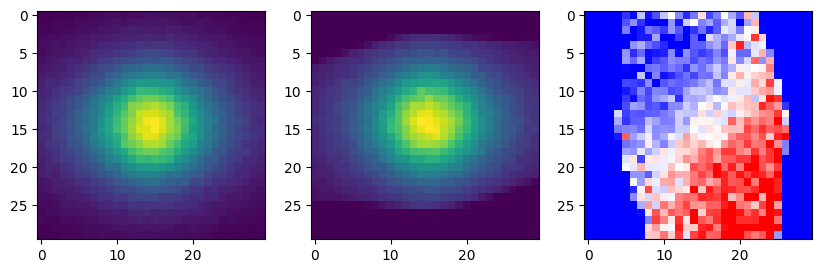

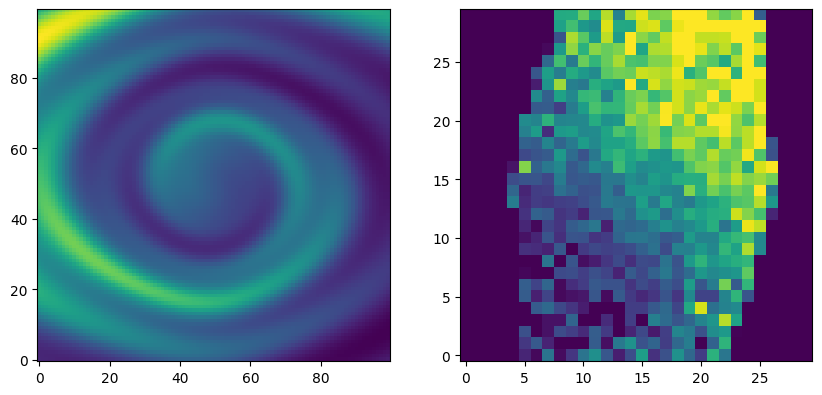

In [6]:
index = -1
print(time_Gyr_forward[-1])
z_final, vz_final = orbits.x(time_Gyr_forward[index]), orbits.vx(time_Gyr_forward[index])

fig = plt.figure(1)
fig.set_size_inches(10, 7)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
bins =30
h_initial, _, _ = np.histogram2d(z_initial, vz_initial, bins=bins, weights=None, 
                                 range=((-z_min_max/8.0, z_min_max/8.0), (-vz_min_max/220, vz_min_max/220)))
ax1.imshow(np.rot90(h_initial))

h_final, _, _ = np.histogram2d(z_final, vz_final, bins=bins, weights=None, 
                               range=((-z_min_max/8.0, z_min_max/8.0), (-vz_min_max/220, vz_min_max/220)))
ax2.imshow(np.rot90(h_final))

ax3.imshow((h_final/h_initial), cmap='bwr', origin='upper',vmin=0.8, vmax=1.2)

fig = plt.figure()
fig.set_size_inches(10, 7)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(np.rot90(df_perturbed.function / equilibrium_df.function), origin='lower')
ax2.imshow(h_final/h_initial, cmap='viridis', origin='lower',vmin=0.8, vmax=1.2)


### Calculate the final action, frequency, angle

In [ ]:
from galpy.actionAngle.actionAngleVertical import actionAngleVertical

aAV_perturbed = actionAngleVertical(pot=vertical_potential)
jz_final, freq_final, angle_final = aAV_perturbed.actionsFreqsAngles(z_final, vz_final)

In [ ]:
delta_J = jz_final - jz_initial
plt.hist(delta_J, bins=20, weights=weights)
plt.show()
plt.hist(angle_final, bins=20, weights=weights); plt.show()
plt.hist(angle_initial, bins=20, weights=weights); plt.show()
plt.scatter(jz_final, angle_final); plt.show()
plt.scatter(delta_J, angle_final); plt.show()